<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
    <h2>Специализация "Машинное обучение и анализ данных"</h2>
</center>
<center>

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам

# <center>Финальный отчёт

## Цели проекта

Данная работы выполнена в рамках учебного соревнования Kaggle Catch Me If You Can ("Alice") (https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2)

Из описания задачи соревнования:

_Будем решать задачу идентификации взломщика по его поведению в сети Интернет. 
Aлгоритм будет анализировать последовательность из нескольких веб-сайтов, посещенных подряд одним и тем же человеком, и определять, Элис это или взломщик (кто-то другой)._

_Данные собраны с прокси-серверов Университета Блеза Паскаля. "A Tool for Classification of Sequential Data", авторы Giacomo Kahn, Yannick Loiseau и Olivier Raynaud._

Целевая метрика – ROC AUC.

## Источники данных

Данные для проекта предоставлены на странице сореванования и доступны по ссылке: https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/data



In [1]:
import pandas as pd
import numpy as np
import os
import pickle

In [2]:
PATH_TO_DATA = '..\data_kaggle_alice'
dt_columns = ["time%d" % i for i in range(1, 11)]
site_columns = ['site%d' % i for i in range(1, 11)]

### train_sessions.csv
В файле находят данные для обучения моделей. В нём содержатся данные по сессиям пользователей. Каждая сессия представляет не более 10 сайтов и не более 30 минут. Более длинные сессии разбиваются на несколько.

Признаки site_i – это индексы посещенных сайтов (расшифровка дана в pickle-файле со словарем site_dic.pkl)

Признаки time_j – время посещения сайтов site_j

Целевой признак target – факт того, что сессия принадлежит Элис (то есть что именно Элис ходила по всем этим сайтам)

In [3]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'), index_col='session_id', parse_dates=dt_columns)
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


### test_sessions.csv
В файле находятся сессии, которые надо классифицировать в рамках соревнования: кому они принадлежат Элис или нет. Структура файла аналогична train_sessions.csv, но нет колонки target

In [4]:
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'), index_col='session_id', parse_dates=dt_columns)
test_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


### sample_submission.csv
В файле находится пример того, как нужно загружать результаты на сайт соревнования

In [5]:
pd.read_csv(os.path.join(PATH_TO_DATA, 'sample_submission.csv'), index_col="session_id").head()

,target
session_id,
1,0.948255
2,0.682483
3,0.502855
4,0.345556
5,0.889428


### site_dic.pkl
В файле хранится pickle дамп словаря {site_id: site_url}

In [6]:
with open(os.path.join(PATH_TO_DATA, 'site_dic.pkl'), "rb") as site_dict_file:
        site_dict = pickle.load(site_dict_file)
        
list(site_dict.items())[:10]

[('www.abmecatronique.com', 25075),
 ('groups.live.com', 13997),
 ('majeureliguefootball.wordpress.com', 42436),
 ('cdt46.media.tourinsoft.eu', 30911),
 ('www.hdwallpapers.eu', 8104),
 ('img378.imageshack.us', 37491),
 ('ecologie.nature.free.fr', 5462),
 ('www.ibcn.intec.ugent.be', 35425),
 ('kissanime.com', 30151),
 ('www.carolineconduiteformation.com', 38268)]

## Aнализ признаков

In [7]:
import matplotlib.pyplot as plt

In [8]:
train_df_alice = train_df[train_df.target==1]
train_df_rest = train_df[train_df.target==0]

### Посещенные сайты
Признаки site_j скорее всего не будут иметь смысла в задаче классификации сессий, т.к. маловероятно, что порядковый номер в сессии будет иметь значение. Эти признаки больше похожи на bag of words, поэтому их надо будет преобразовать в подобный формат.

### Время работы в интернете

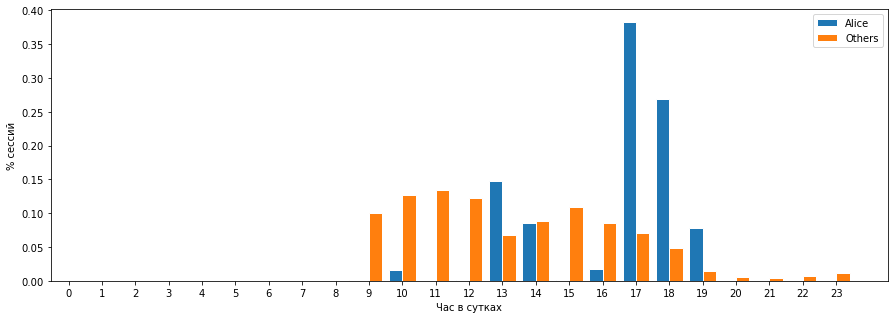

In [9]:
# session start: minutes after 00:00
day_minutes_alice = (train_df_alice.time1.dt.hour*60 + train_df_alice.time1.dt.minute).value_counts()
day_minutes_rest = (train_df_rest.time1.dt.hour*60 + train_df_rest.time1.dt.minute).value_counts()
plt.figure(figsize=(15, 5))
plt.hist([train_df_alice.time1.dt.hour, train_df_rest.time1.dt.hour], 
         density=True, label=["Alice", "Others"], bins=range(0, 24), edgecolor="w",  align='right')
plt.xlabel("Час в сутках")
plt.ylabel("% сессий")
plt.legend()
plt.xticks(ticks=range(0, 24), labels=range(0, 24) )
plt.show()

Alice появляется в интернете меньше, чем все остальные. Пики работы так же не совпадают. Время в сутках стоит учитывать, как признак.
В качестве признака лучше использовать не час в сутках, а какую-то долю часа, например, 12 или 5 минут, чтобы учитывать начало работы не с ровного часа.

### Дни работы в Интернете

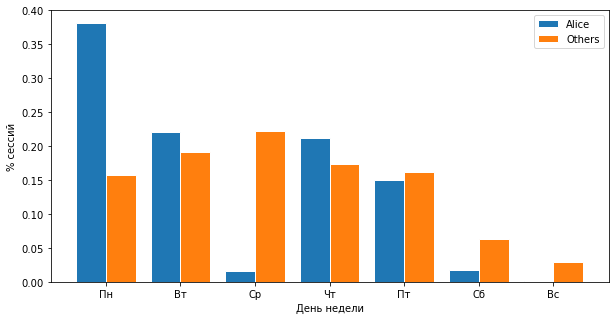

In [10]:
plt.figure(figsize=(10, 5))
bins = len(train_df.time1.dt.dayofweek.value_counts())
plt.hist([train_df_alice.time1.dt.dayofweek, train_df_rest.time1.dt.dayofweek], 
         density=True, label=["Alice", "Others"], bins=range(0, 8), edgecolor="w", align='right')
plt.xlabel("День недели")
plt.ylabel("% сессий")
plt.xticks(ticks=range(1, 8), labels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] )
plt.legend()
plt.show()

Недельный график Alice явно отличается от остальных. День недели нужно использовать, как признак.

### Месячный график

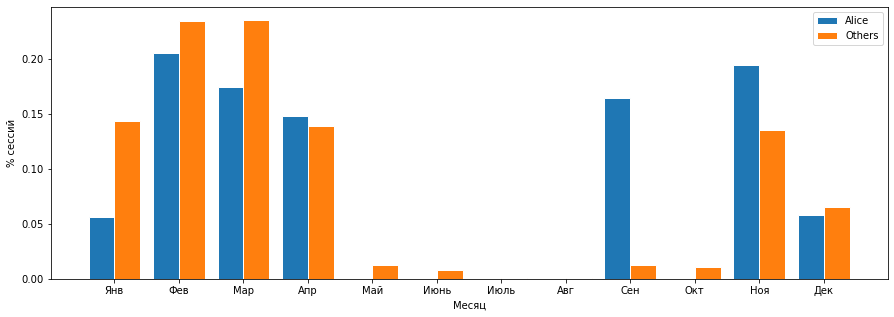

In [11]:
plt.figure(figsize=(15, 5))
bins = len(train_df.time1.dt.dayofweek.value_counts())
plt.hist([train_df_alice.time1.dt.month, train_df_rest.time1.dt.month], 
         density=True, label=["Alice", "Others"], bins=list(range(1, 14)), edgecolor="w", align='right')
plt.xlabel("Месяц")
plt.ylabel("% сессий")
plt.xticks(ticks=range(2, 14), labels=['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июнь', 'Июль', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'])
plt.legend()
plt.show()

Alice сидит в Интернете не круглый год. Надо использовать месяц или декаду дней от начала года в качестве признака.

### Длина сессии (сайты)

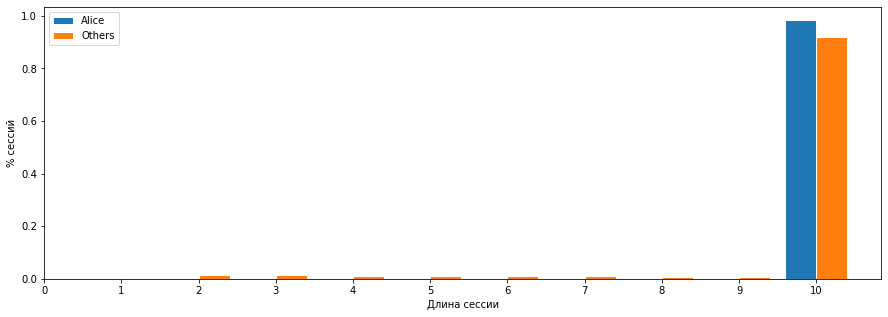

In [12]:
sites_count_alice = len(site_columns) - np.sum(train_df_alice[site_columns].isna(), axis=1)
sites_count_rest = len(site_columns) - np.sum(train_df_rest[site_columns].isna(), axis=1)
plt.figure(figsize=(15, 5))
plt.hist([sites_count_alice, sites_count_rest], 
         density=True, label=["Alice", "Others"], bins=range(1, 11), edgecolor="w", align='right')
plt.xlabel("Длина сессии")
plt.ylabel("% сессий")
plt.legend()
plt.xticks(ticks=range(0, 11), labels=range(0, 11))
plt.show()

В основном сессии имеют длину 10. Надо посмотреть отдельно сессии длиины меньше 10.

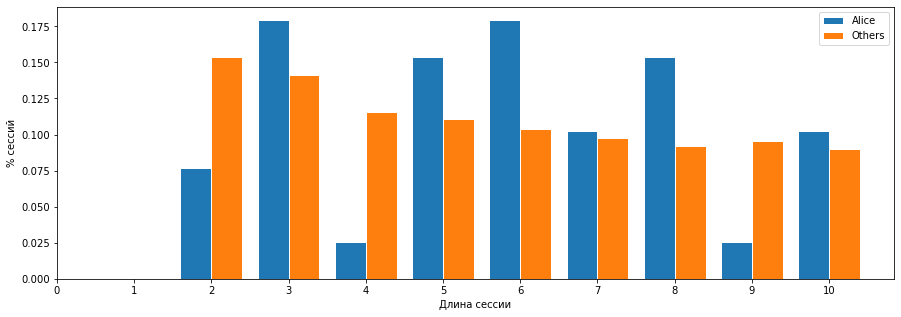

In [13]:
sites_count_alice = len(site_columns) - np.sum(train_df_alice[site_columns].isna(), axis=1)
sites_count_alice = sites_count_alice[sites_count_alice != 10]
sites_count_rest = len(site_columns) - np.sum(train_df_rest[site_columns].isna(), axis=1)
sites_count_rest = sites_count_rest[sites_count_rest != 10]
plt.figure(figsize=(15, 5))
plt.hist([sites_count_alice, sites_count_rest], 
         density=True, label=["Alice", "Others"], bins=range(1, 11), edgecolor="w", align='right')
plt.xlabel("Длина сессии")
plt.ylabel("% сессий")
plt.legend()
plt.xticks(ticks=range(0, 11), labels=range(0, 11))
plt.show()

По некоторым сессиям разница есть. Можно добавить, как категориальный признак.

### Длина сессии (время)

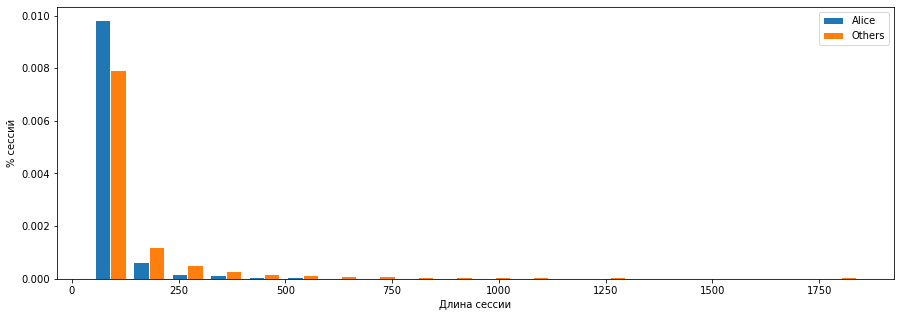

In [14]:
session_time_alice = (np.max(train_df_alice[dt_columns], axis=1) - np.min(train_df_alice[dt_columns], axis=1)).dt.seconds
session_time_rest = (np.max(train_df_rest[dt_columns], axis=1) - np.min(train_df_rest[dt_columns], axis=1)).dt.seconds
plt.figure(figsize=(15, 5))
plt.hist([session_time_alice, session_time_rest], 
         density=True, label=["Alice", "Others"], bins=20, edgecolor="w", align='right')
plt.xlabel("Длина сессии")
plt.ylabel("% сессий")
plt.legend()
plt.show()

### Среднее время на сайт

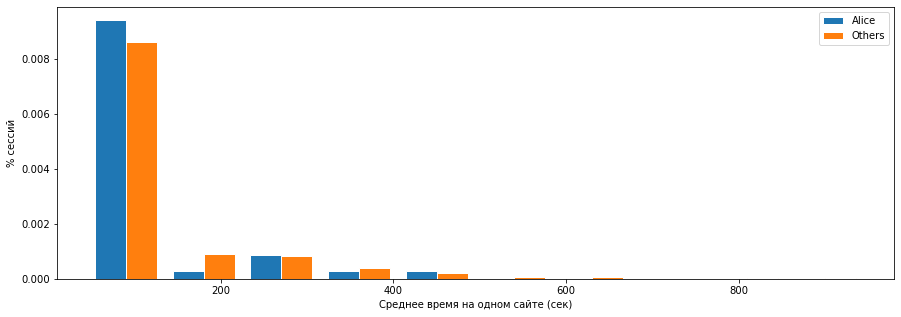

In [15]:
time_per_site_alice = session_time_alice / sites_count_alice
time_per_site_rest = session_time_rest / sites_count_rest
plt.figure(figsize=(15, 5))
plt.hist([time_per_site_alice, time_per_site_rest], 
         density=True, label=["Alice", "Others"], bins=10, edgecolor="w", align='right')
plt.xlabel("Среднее время на одном сайте (сек)")
plt.ylabel("% сессий")
plt.legend()
plt.show()

## Подготовка данных
Подготовка данных будет сделана при помощи стандартных классов sklearn и их расширений, которые будут объединяться при помощи паплайнов

In [16]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

### Baseline
Базовые признаки заданы самим Capstone-проектом: преобразование сессий с сайтами site1..site10 в мешок слов, где в качестве слов используются сайты. Каждый сайт считается независимым признаком, т.е. используются n-граммы (1, 1).

Размер обучающей выборки - 0.7. Размер тестовой выборки - 0.3. Предполагается, что порядок сессий имеет значение, поэтому в тренировочной выборке идёт начало всего датасета, в тестовой - конец.

In [17]:
class SitesPreparator(BaseEstimator, TransformerMixin):
    '''
    Prepares CountVectorizer friendly list of strings with sites
    Consumes pandas dataframe
    ----------
    Example 
    [[1, 2, 3],
    [4, 5, 6]]
    --->
    ["1 2 3", "4 5 6"]
    '''
    def __init__(self, site_columns):
        self.site_columns = site_columns
        super().__init__()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X[self.site_columns].fillna(0).astype(int).values.tolist()
        return [" ".join(map(str, row)) for row in X]

In [18]:
sites_pipeline_base = Pipeline([("site_prep", SitesPreparator(site_columns)),
                           ("site_vect", CountVectorizer(token_pattern=r"(?u)[1-9]\w*\b",  
                                                               ngram_range=(1, 1), 
                                                               max_features=50000))
])

In [19]:
y = train_df.target
X_train_base_sparse = sites_pipeline_base.fit_transform(train_df[train_df.columns[:-1]])
X_test_base_sparse = sites_pipeline_base.transform(test_df)

# split train data to train and validation
train_share = int(.7 * X_train_base_sparse.shape[0])
X_train_base, y_train_base = X_train_base_sparse[:train_share, :], y[:train_share]
X_valid_base, y_valid_base = X_train_base_sparse[train_share:, :], y[train_share:]

### Дополнительные признаки
Признаки посещённых сайтов будут кодированы при помощи TF-IDF. n-граммы использованы вида (1, 3). Максимальное количество признаков - 50,000

Допонительно добавлены категориальные признаки. Для кодирования используется 
- session_start - время начала сессии
- dayofweek - день недели
- month - месяц
- sites_count - количество сайтов

Дополнительно добавлены числовые признаки:
- session_time - длительность сессии в секундах
- time_per_site - среднее время на сайт в сессии

Разделение на обучающую и тестовые выборки проводится при помощи случайной стратифицированной выборки. Размер обучающей выборки - 0.8 

In [20]:
class ExtAttributeAddr(BaseEstimator, TransformerMixin):
    """
    Creates additional categorical features
    session_start - session start: bin number, not exact time
    dayofweek - день недели
    month - месяц
    sites_count - количество сайтов
    """
    def __init__(self, site_columns, date_columns, start_time_bin_length_minutes):
        self.site_columns = site_columns
        self.date_columns = date_columns
        self.start_time_bin_length_minutes = start_time_bin_length_minutes
        super().__init__()
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        session_start = (X[self.date_columns[0]].dt.hour*60 + X[self.date_columns[0]].dt.minute) // self.start_time_bin_length_minutes
        dayofweek = X[self.date_columns[0]].dt.dayofweek
        month = X[self.date_columns[0]].dt.month
        sites_count = len(self.site_columns) - np.sum(X[site_columns].isna(), axis=1)
        return np.c_[session_start, dayofweek, month, sites_count]

In [21]:
class ExtNumericAttributeAddr(BaseEstimator, TransformerMixin):
    """
    Creates additional numeric features
    session_time - длительность сессии в секундах
    time_per_site - среднее время на сайт в сессии
    """
    def __init__(self, site_columns, date_columns):
        self.site_columns = site_columns
        self.date_columns = date_columns
        super().__init__()
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        sites_count = len(site_columns) - np.sum(X[site_columns].isna(), axis=1)
        session_time = (np.max(X[dt_columns], axis=1) - np.min(X[dt_columns], axis=1)).dt.seconds
        time_per_site = session_time / sites_count
        return np.c_[session_time, time_per_site]

In [22]:
sites_pipeline = Pipeline([("site_prep", SitesPreparator(site_columns)),
                           ("site_vect", TfidfVectorizer(token_pattern=r"(?u)[1-9]\w*\b", 
                                                               ngram_range=(1, 3), 
                                                               max_features=50000))
])

ext_features_pipeline = Pipeline([("cat_feat_prep", ExtAttributeAddr(site_columns, dt_columns, 30)),
                                 ("cat_feat_enc", OneHotEncoder())
])

ext_num_features_pipeline = Pipeline([
    ("num_feat_prep", ExtNumericAttributeAddr(site_columns, dt_columns)),
    ("num_feat_scale", StandardScaler())
])

In [23]:
%%time
full_feature_pipe = FeatureUnion(transformer_list=[("sites", sites_pipeline),
                                                  ("cat_feat", ext_features_pipeline),
                                                  ("num_feat", ext_num_features_pipeline)
                                                  ])

X_train_sparse = full_feature_pipe.fit_transform(train_df[train_df.columns[:-1]])
X_test_sparse = full_feature_pipe.transform(test_df)


X_train, X_valid, y_train, y_valid = train_test_split(X_train_sparse, y, test_size=0.2, stratify=y, random_state=17)

Wall time: 12.4 s


## Выбор моделей

In [24]:
from sklearn.linear_model import SGDClassifier, LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

In [25]:
def validate_score(classifier, X_train, y_train, X_valid, y_valid):
    clf = classifier.fit(X_train, y_train)
    print(type(clf).__name__, "ROC-AUC on validation dataset:", roc_auc_score(y_valid, clf.predict_proba(X_valid)[:, 1]))
    print(type(clf).__name__, "accuracy on validation dataset:", accuracy_score(y_valid, clf.predict(X_valid)))

In [26]:
def write_to_submission_file(predicted_labels, out_file, target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

### Models Baseline (SGDClassifier)
Базовый классификатор задан в Capstone проекте, это SGDClassifier. В качестве функции потерь используется logit.

In [27]:
sgd_base_params = {"loss":"log", "random_state":17, "n_jobs":-1}
validate_score(SGDClassifier(**sgd_base_params), X_train_base, y_train_base, X_valid_base, y_valid_base)

SGDClassifier ROC-AUC on validation dataset: 0.9336212361738347
SGDClassifier accuracy on validation dataset: 0.991257936873102


In [28]:
sgd_base = SGDClassifier(**sgd_base_params).fit(X_train_base_sparse, y)
sgd_base_test_pred_proba = sgd_base.predict_proba(X_test_base_sparse)[:, 1]
write_to_submission_file(sgd_base_test_pred_proba, "lab_answers/report_alice_SGDCLassifer_baseline.csv")

**Kaggle score: 0.91646**

### LogisticRegression (базовый набор признаков)

Проверка классификатора LogisticRegression с настройками по умолчанию на базовом наборе признаков.

In [29]:
lr_base_params = {"n_jobs": 1, "multi_class": "ovr", "random_state": 17, "solver": "liblinear"}
validate_score(LogisticRegression(**lr_base_params), X_train_base, y_train_base, X_valid_base, y_valid_base)

LogisticRegression ROC-AUC on validation dataset: 0.9583130531300045
LogisticRegression accuracy on validation dataset: 0.9918495050546214


In [30]:
lr_base = LogisticRegression(**lr_base_params).fit(X_train_base_sparse, y)
lr_base_test_pred_proba = lr_base.predict_proba(X_test_base_sparse)[:, 1]
write_to_submission_file(lr_base_test_pred_proba, "lab_answers/report_alice_LR_base.csv")

**Kaggle score: 0.90812**

### LogisticRegression (дополнительные признаки)

Проверка классификатора LogisticRegression с настройками по умолчанию на расширенном наборе признаков.

In [31]:
lr_base_params = {"n_jobs": 1, "multi_class": "ovr", "random_state": 17, "solver": "liblinear"}
validate_score(LogisticRegression(**lr_base_params), X_train, y_train, X_valid, y_valid)

LogisticRegression ROC-AUC on validation dataset: 0.9857961208477058
LogisticRegression accuracy on validation dataset: 0.9940449194486621


In [32]:
lr_ext = LogisticRegression(**lr_base_params).fit(X_train_sparse, y)
lr_ext_test_pred_proba = lr_ext.predict_proba(X_test_sparse)[:, 1]
write_to_submission_file(lr_ext_test_pred_proba, "lab_answers/report_alice_LR_base_ext.csv")

**Kaggle score: 0.95032**

### LogisticRegression (дополнительные признаки, оптимизация С)

In [33]:
def LogisticRegression_C_search(X, y, X_valid, y_valid, Cs, cv):
    lr_cv = LogisticRegressionCV(Cs=Cs, cv=cv, scoring="roc_auc", n_jobs=-1, multi_class="ovr", random_state=17, solver="liblinear")
    lr_cv.fit(X, y)
    best_C = lr_cv.Cs_[np.argmax(np.mean(lr_cv.scores_[1], axis=0))]
    lr = LogisticRegression(C=best_C, n_jobs=-1, multi_class="ovr").fit(X, y)
    
    plt.figure(figsize=(12, 5))
    plt.plot(np.mean(lr_cv.scores_[1], axis=0))
    plt.xlabel("C values")
    plt.xticks(labels=np.round(Cs, 4), ticks=range(0, len(Cs)))
    plt.ylabel("Mean ROC-AUC during CV")
    plt.show()
    
    print("Optimal C:", best_C)
    print("ROC-AUC: ", roc_auc_score(y_valid, lr.predict_proba(X_valid)[:, 1]))
    
    return best_C 

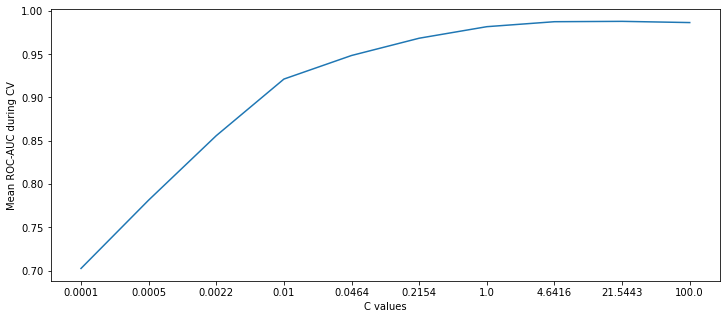

Optimal C: 21.54434690031882
ROC-AUC:  0.9917837862959
Wall time: 31.3 s


In [34]:
%%time
Cs = np.logspace(-4, 2, 10)
C_opt = LogisticRegression_C_search(X_train, y_train, X_valid, y_valid, Cs, 4)

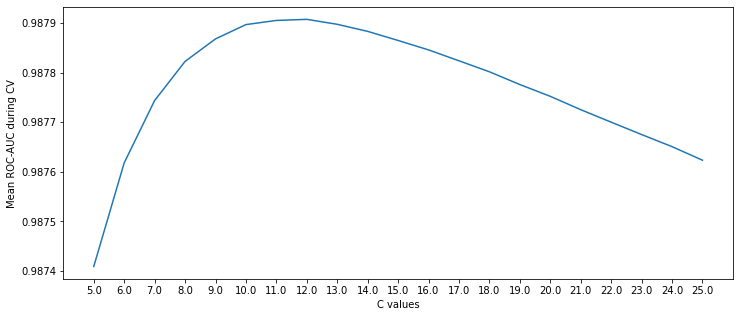

Optimal C: 12.0
ROC-AUC:  0.991220157157197
Wall time: 1min 35s


In [35]:
%%time
Cs = np.linspace(5, 25, 21)
C_opt = LogisticRegression_C_search(X_train, y_train, X_valid, y_valid, Cs, 4)

In [36]:
print("Оптимальный параметр С:", C_opt)
lr_opt_params = lr_base_params.copy()
lr_opt_params["C"] = C_opt

Оптимальный параметр С: 12.0


In [37]:
validate_score(LogisticRegression(**lr_opt_params), X_train, y_train, X_valid, y_valid)

LogisticRegression ROC-AUC on validation dataset: 0.9909426561867457
LogisticRegression accuracy on validation dataset: 0.9947350777907046


In [38]:
lr_opt = LogisticRegression(**lr_opt_params).fit(X_train_sparse, y)
lr_opt_test_pred_proba = lr_opt.predict_proba(X_test_sparse)[:, 1]
write_to_submission_file(lr_opt_test_pred_proba, "lab_answers/report_alice_LR_opt.csv")

**Kaggle score: 0.95098**

## Выводы

Несмотря на то, что финальная модель существенно лучше Baseline c использованием SGDClassifier, её ценность  довольно низкая, что подтверждается общим результатом в соревновании на Kaggle. Необходимо попробовать другие способы классификации, например, XGBoost. Так же стоит внимательнее изучить признаки. Скорее всего в существующих есть проблемы. Возможно получится придумать дополнительные.